In [25]:
import lightkurve as lk


import glob, os
from os import listdir
from os.path import isfile, join
import fnmatch

#Needed for making plots
import matplotlib.pyplot as plt
from matplotlib import pylab
from pylab import *
import matplotlib.gridspec as gridspec

#Needed for handling lists, arrays, strings, importing data and general math
import numpy as np
# import pandas as pd #optional (may be used in future)

#Needed for r
import astropy
from astropy.stats import BoxLeastSquares # <--- Super Important! We use this to search for periodic events in our data.
# print(astropy.__version__)

import warnings
# warnings.filterwarnings(action='once') #useful to see a warning once but that's it
warnings.simplefilter("ignore", category=PendingDeprecationWarning)

from transitleastsquares import catalog_info
from transitleastsquares import period_grid

import wotan
from wotan import flatten


from astroML.time_series import lomb_scargle

In [2]:

def ChauventsCriteron(x, y, z, mean=None, stdv=None):
    from scipy.special import erfc
    if mean is None:
        mean = y.mean()           # Mean of incoming array y
    if stdv is None:
        stdv = y.std()            # Its standard deviation
    N = len(y)                   # Lenght of incoming arrays
    criterion = 1.0/(2*N)        # Chauvenet's criterion
    d = abs(y-mean)/stdv         # Distance of a value to mean in stdv's
    d /= 2.0**0.5                # The left and right tail threshold values
    prob = erfc(d)               # Area normal dist.    
    filter = prob >= criterion   # The 'accept' filter array with booleans
    
    xf = x[filter]; yf = y[filter]; zf=z[filter]

    return xf,yf,zf
# For some light curves, where there are flare events, we may need to 
# turn this off. (Will add in future versions)

In [5]:
#path where data is stored
SectorNum = int(input()) #<--- will ask you for Sector number: enter 1, 2, 3, etc
#^^^ A new entry field underthis cell will open and will not proceed without an input number.
# Since we are checking out Sector 1, enter 1.

print("TESS Sector",'{:02d}'.format(SectorNum)) 
# ^^^ This adds a 0 in front of numbers 1-9. For numbers 10 and greater, this will not put a 0 in front.

path = '/Users/felizd/Desktop/TESS/Sector'+str('{:02d}'.format(SectorNum))+'/curves/clean'

#path where figures will be saved
figpath = '/Users/felizd/Desktop/TESS/Sector'+str('{:02d}'.format(SectorNum))+'/plots/' 

#path where we will save our light curves later
savepath = '/Users/felizd/Desktop/TESS/Sector'+str('{:02d}'.format(SectorNum))+'/processed/' 

#This portion of code is designed to recursively search through a directory 
#for all files in the path that end with .lc in their filename
data = [os.path.join(dirpath, f) # an array of path names to be looped over
    for dirpath, dirnames, files in os.walk(path) #recursively searches through directory
    for f in fnmatch.filter(files, '*.lc')] #finds every file (*) that ends with .lc

data.sort(key=lambda x: int(os.path.basename(x).split('_')[0])) #sorts them in alphanumeric order based on TIC ID (smallest first)

print ("number of files: ",len(data)) #number of files)

1
TESS Sector 01
number of files:  917


## Let's compare with our previous pipeline using Lightkurve's detrending with the new Wotan tools:

See https://github.com/hippke/wotan for more details.


0


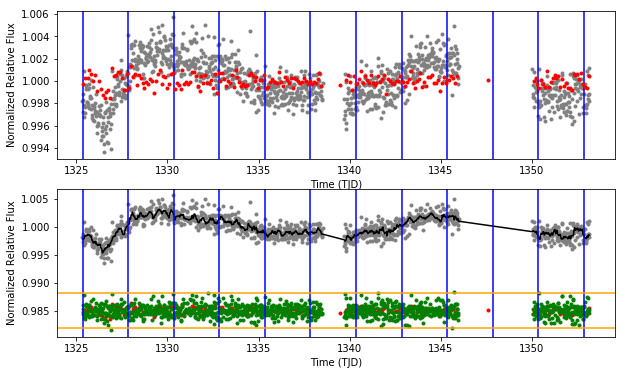

1


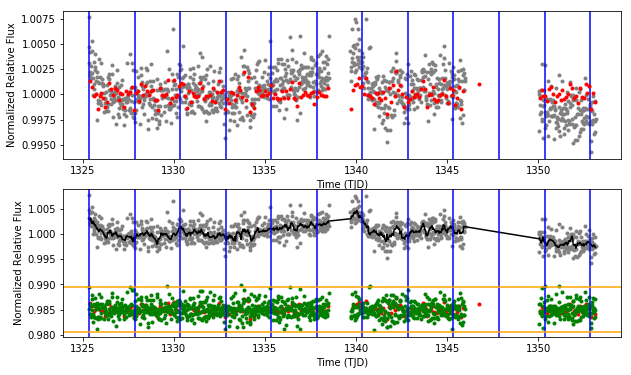

2


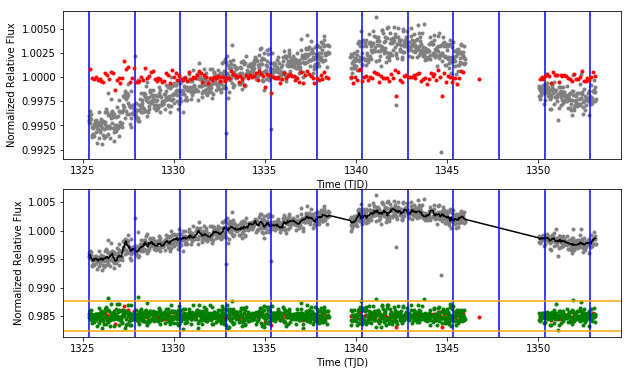

3


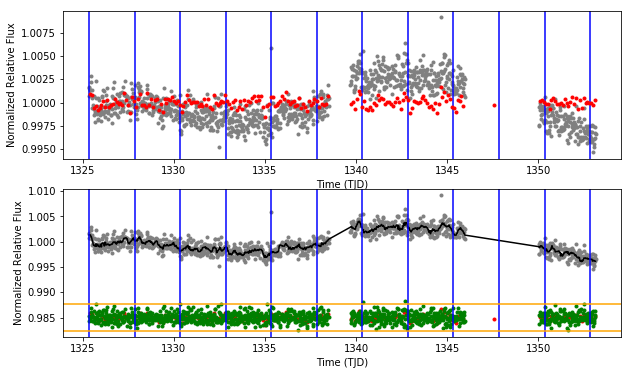

4


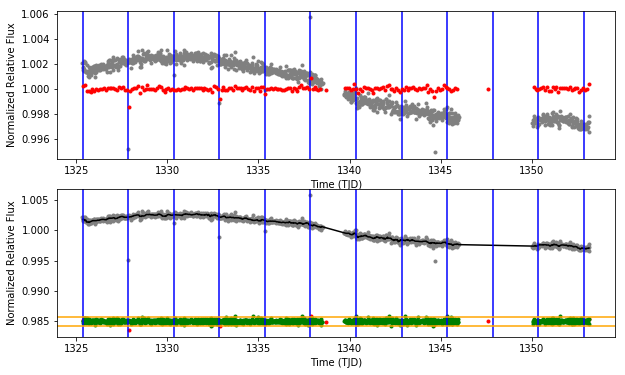

5


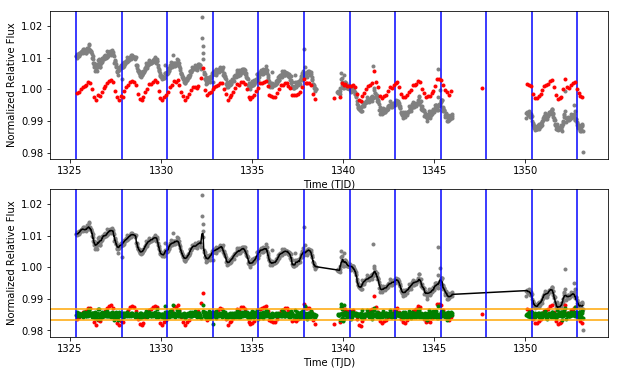

6


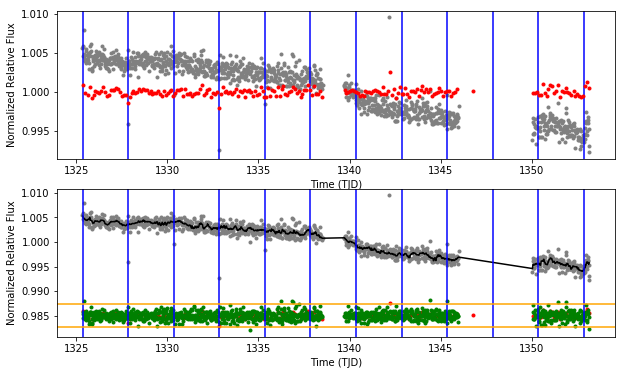

7


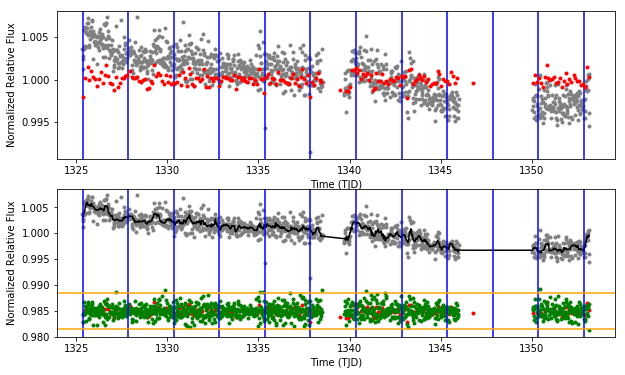

8


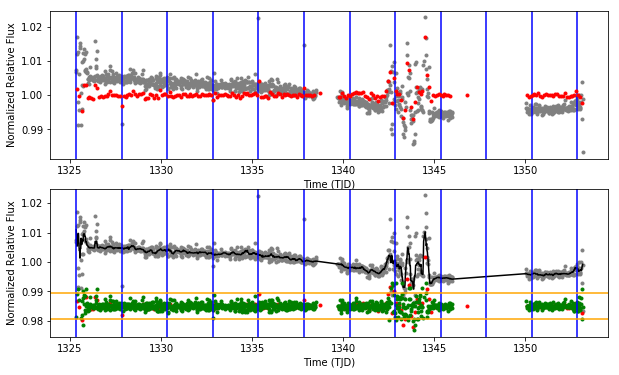

9


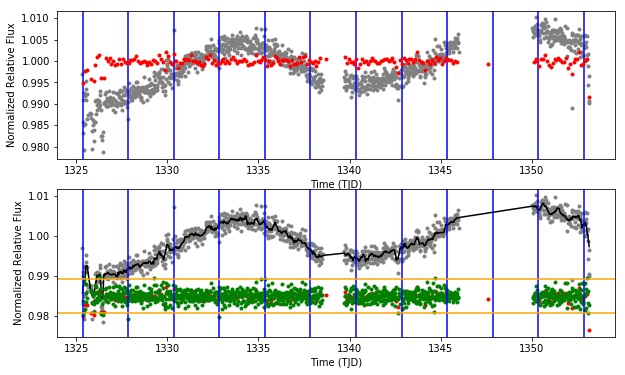

In [6]:
# for ii in range(len(data)): #creating a for loop to show light curve figures for all files
for ii in range(10): #creating a for loop to show light curve figures for all files    
    print(ii)
    time     = np.transpose(np.loadtxt(data[ii]))[0] #first  (zero indexing in python) column 
    mag      = np.transpose(np.loadtxt(data[ii]))[1] #second (zero indexing in python) column 
    magerror = np.transpose(np.loadtxt(data[ii]))[2] #third (zero indexing in python) column 
    
    mask = np.where(np.isnan(mag)==False)[0] #creating array of only real numbers by setting np.isnan(mag)==False. 
    time = time[mask]                        #Sometimes there are holes in data filled with NaNs
    mag = mag[mask]
    magerror = magerror[mask]
    
    flux = 10.0**(mag/-2.5)/np.mean(10.0**(mag/-2.5))
    fluxerror = flux*(10.0**(magerror/2.5)-1.0)
    
    #known bad data points:
    if SectorNum==1:
        jittermask = (time < 1346) | (time > 1350)
    
    #removing outliers with Chauvenet's criterion
    t2,f2,fe2 = ChauventsCriteron(time[jittermask],flux[jittermask],fluxerror[jittermask])
    
    lc = lk.LightCurve(t2,f2,fe2)
    
    bin_size = 5
    cad = time[1]-time[0]
    #now let's define a window size to smooth our data with:

    window_size = int(3.0/cad) #number of data points in 5 hours
    if (window_size % 2) == 0: #must be odd. If not, there will be an error
        window_size = window_size+1
        
    detrended_lc = lc.flatten(window_length=window_size).bin(binsize=bin_size)
    
    window_size_wotan = 5.0/24.0 # The length of the filter window in units of time (days)
    flatten_lc, trend_lc = flatten(t2, f2, window_length=window_size_wotan, return_trend=True, method='biweight',robust=True)


    nanmask = np.where(np.isnan(flatten_lc)==False)[0]
    t2 = t2[nanmask]
    f2 = f2[nanmask]
    fe2 =fe2[nanmask]

    flatten_lc = flatten_lc[nanmask]
    trend_lc = trend_lc[nanmask]
#     Try another iteration of outlier removal
    t2_wotan,f2_wotan,fe2_wotan = ChauventsCriteron(t2,flatten_lc,fe2)
    
    fig = plt.figure(figsize=(10,6))
    ax1 = fig.add_subplot(211)
    ax1.plot(lc.time,lc.flux,color='grey',marker='.',linestyle='none')
    for x in range(12):
        plt.axvline(x=(t2[0]+x*2.5),color='b')
    ax1.plot(detrended_lc.time,detrended_lc.flux,color='red',marker='.',linestyle='none')
    ax1.set_xlabel("Time (TJD)")
    ax1.set_ylabel("Normalized Relative Flux")
    
    ax2 = fig.add_subplot(212)
    ax2.plot(lc.time,lc.flux,color='grey',marker='.',linestyle='none')
    ax2.plot(t2,trend_lc,'k')
    offset = 0.015
    ax2.plot(detrended_lc.time,detrended_lc.flux-offset,color='red',marker='.',linestyle='none')
    ax2.plot(t2_wotan,f2_wotan-offset,color='green',marker='.',linestyle='none')
    for x in range(12):
        plt.axvline(x=(t2[0]+x*2.5),color='b')

    plt.axhline(y=np.mean(f2_wotan)+3*np.std(f2_wotan)-offset,color='orange')
    plt.axhline(y=np.mean(f2_wotan)-3*np.std(f2_wotan)-offset,color='orange')
    ax2.set_xlabel("Time (TJD)")
    ax2.set_ylabel("Normalized Relative Flux") 
    plt.show()

## In figures above, the grey and black lines are the undetrended data with modeled trends in black. The green data is our new flattened data and the red data is our old method using LightKurve. The yellow horizontal lines are the mean + 3 standard deviations of the green data. The Blue lines are the 2.5 momentum dump rate for this sector. For most data sets, it appears the outliers due to the momentum dumps are removed. Hopefully, this takes care of that bias in our BLS/TLS results.

## Let's try BLS with these green results. Most 2.5 day momentum dump outliers are minimized but remain, let's see if this is an issue.

        Use astropy.stats.LombScargle instead. [__main__]


 
iteration 1
Applying Biweighted Midcorrelation Function...
 
iteration 2
Applying Biweighted Midcorrelation Function...
 
iteration 3
Applying Biweighted Midcorrelation Function...
 
iteration 4
Applying Biweighted Midcorrelation Function...
 
file:
TIC  25132720   1   4   Sector01
best period:  1.769842568251748
best T0:  1.2410987127742428


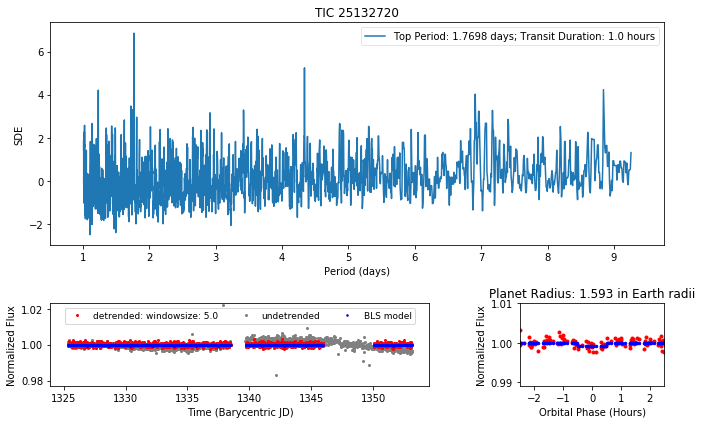


 
iteration 5
Applying Biweighted Midcorrelation Function...
 
file:
TIC  25167696   3   1   Sector01
best period:  5.15253378251323
best T0:  3.069382227433196


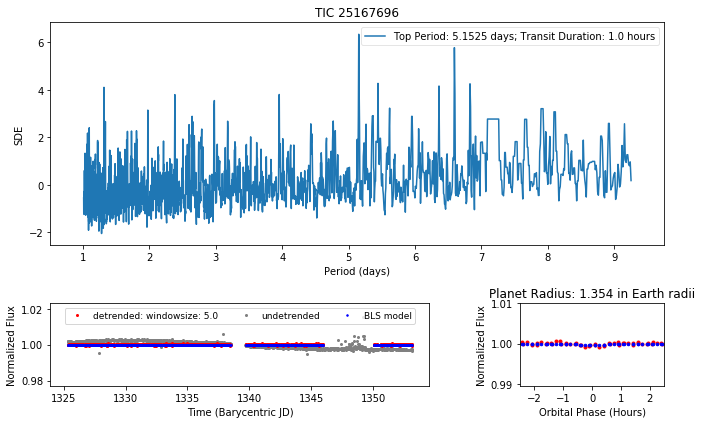


 
iteration 6
Applying Quasi Periodic GP...
Segment 1 of 3
Segment 2 of 3
Segment 3 of 3


        Use astropy.stats.LombScargle instead. [__main__]


 
iteration 7
Applying Biweighted Midcorrelation Function...
 
iteration 8
Applying Biweighted Midcorrelation Function...
 
iteration 9
Applying Biweighted Midcorrelation Function...
 
iteration 10
Applying Biweighted Midcorrelation Function...
 
iteration 11
Applying Biweighted Midcorrelation Function...
 
file:
TIC  29717846   4   1   Sector01
best period:  9.031440466771528
best T0:  7.759708518023672


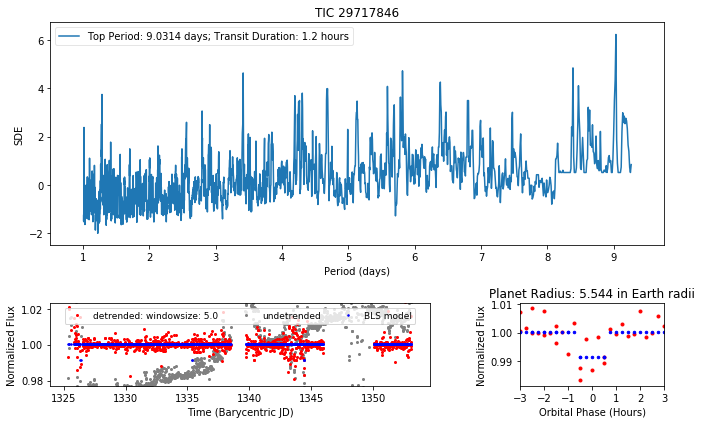


 
iteration 12
Applying Biweighted Midcorrelation Function...
 
iteration 13
Applying Biweighted Midcorrelation Function...
 
iteration 14
Applying Biweighted Midcorrelation Function...
 
iteration 15
Applying Biweighted Midcorrelation Function...
 
iteration 16
Applying Biweighted Midcorrelation Function...
 
iteration 17
Applying Biweighted Midcorrelation Function...
 
iteration 18
Applying Quasi Periodic GP...
Segment 1 of 3
Segment 2 of 3
Segment 3 of 3


        Use astropy.stats.LombScargle instead. [__main__]


 
iteration 19
Applying Biweighted Midcorrelation Function...
 
iteration 20
Applying Biweighted Midcorrelation Function...
 
iteration 21
Applying Biweighted Midcorrelation Function...
 
iteration 22
Applying Biweighted Midcorrelation Function...
 
iteration 23
Applying Biweighted Midcorrelation Function...
 
iteration 24
Applying Biweighted Midcorrelation Function...
 
file:
TIC  32154622   1   4   Sector01
best period:  2.9328985185921255
best T0:  0.8163852630260067


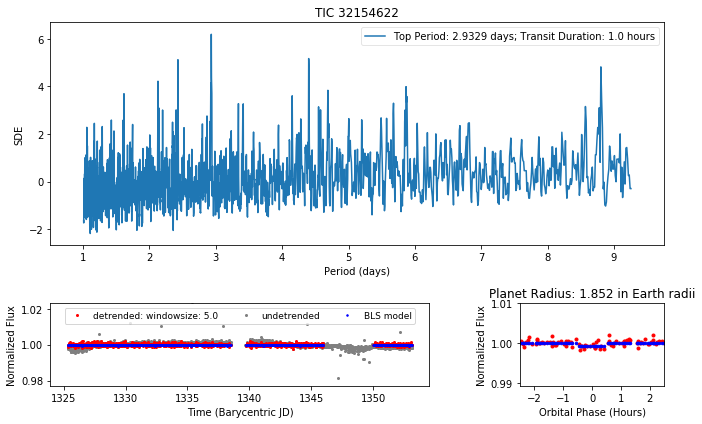


 
iteration 25
Applying Quasi Periodic GP...
Segment 1 of 3
Segment 2 of 3


/Users/felizd/anaconda/envs/py3.6/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.41348953e+05, -1.81308618e+01,  1.69553667e+03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)


Segment 3 of 3


/Users/felizd/anaconda/envs/py3.6/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([26100.86425781,  -123.40759277, 19017.78882599]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 69, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)
        Use astropy.stats.LombScargle instead. [__main__]


 
iteration 26
Applying Biweighted Midcorrelation Function...
 
file:
TIC  32197508   3   1   Sector01
best period:  8.564028914858843
best T0:  8.553861445071451


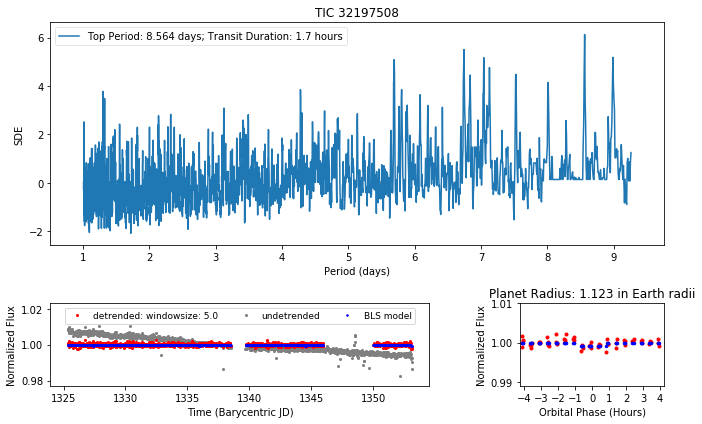


 
iteration 27
Applying Biweighted Midcorrelation Function...
 
iteration 28
Applying Quasi Periodic GP...
Segment 1 of 3
Segment 2 of 3


/Users/felizd/anaconda/envs/py3.6/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 101881.63818359, -224723.93078613, 1014118.91109467]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 98, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


Segment 3 of 3


        Use astropy.stats.LombScargle instead. [__main__]


 
iteration 29
Applying Biweighted Midcorrelation Function...
 
iteration 30
Applying Biweighted Midcorrelation Function...
 
iteration 31
Applying Biweighted Midcorrelation Function...
 
file:
TIC  33839044   2   4   Sector01
best period:  3.8392063756751953
best T0:  3.187643392057621


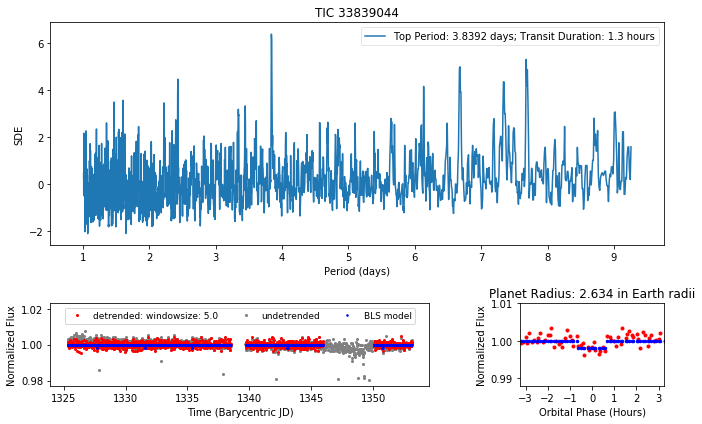


 
iteration 32
Applying Biweighted Midcorrelation Function...
 
iteration 33
Applying Biweighted Midcorrelation Function...
 
iteration 34
Applying Biweighted Midcorrelation Function...
 
iteration 35
Applying Biweighted Midcorrelation Function...
 
iteration 36
Applying Quasi Periodic GP...
Segment 1 of 3
Segment 2 of 3
Segment 3 of 3


/Users/felizd/anaconda/envs/py3.6/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.29593052e+05, -7.21682587e+01,  3.36969965e+04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 76, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)
        Use astropy.stats.LombScargle instead. [__main__]


 
iteration 37
Applying Biweighted Midcorrelation Function...
 
iteration 38
Applying Biweighted Midcorrelation Function...
 
iteration 39
Applying Biweighted Midcorrelation Function...
 
iteration 40
Applying Quasi Periodic GP...
Segment 1 of 3
Segment 2 of 3
Segment 3 of 3


        Use astropy.stats.LombScargle instead. [__main__]


 
iteration 41
Applying Biweighted Midcorrelation Function...
 
file:
TIC  38759628   1   4   Sector01
best period:  7.463400940000942
best T0:  4.368715953166681


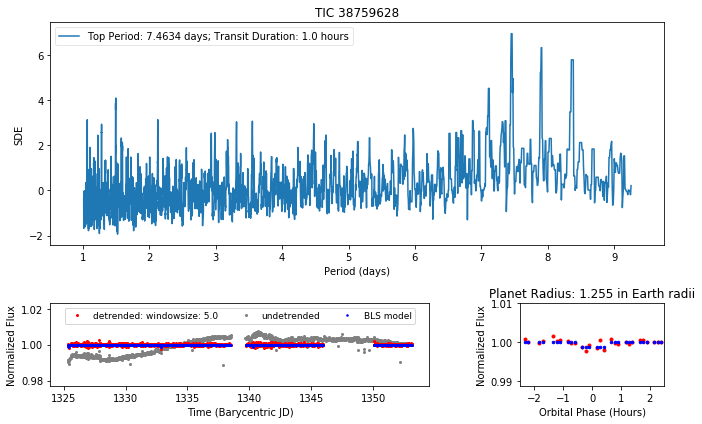


 
iteration 42
Applying Biweighted Midcorrelation Function...
 
iteration 43
Applying Biweighted Midcorrelation Function...
 
iteration 44
Applying Biweighted Midcorrelation Function...
 
iteration 45
Applying Biweighted Midcorrelation Function...
 
iteration 46
Applying Quasi Periodic GP...
Segment 1 of 3
Segment 2 of 3


/Users/felizd/anaconda/envs/py3.6/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 259625.1885376 , 1090462.26224518,  228725.60227585]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)


Segment 3 of 3


/Users/felizd/anaconda/envs/py3.6/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  229941.09109497, -1829087.36662292,     2193.64973716]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 91, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)


 
file:
TIC  38847671   2   3   Sector01
best period:  1.4995590912678352
best T0:  1.0163013192337065


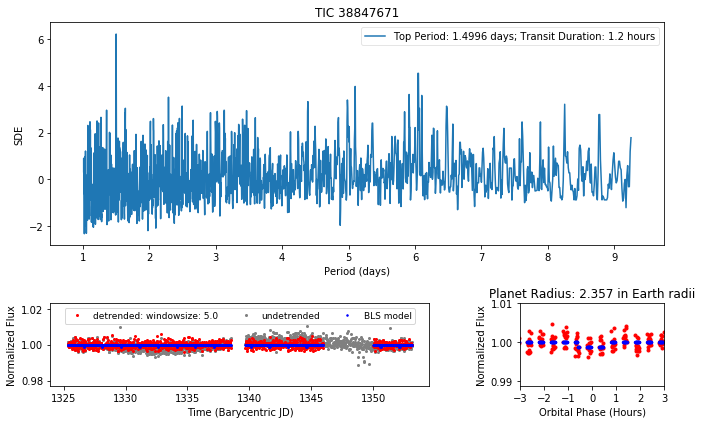


 
iteration 47
Applying Biweighted Midcorrelation Function...


        Use astropy.stats.LombScargle instead. [__main__]


 
iteration 48
Applying Quasi Periodic GP...
Segment 1 of 3
Segment 2 of 3
Segment 3 of 3


        Use astropy.stats.LombScargle instead. [__main__]


 
iteration 49
Applying Biweighted Midcorrelation Function...
 
iteration 50
Applying Quasi Periodic GP...
Segment 1 of 3
Segment 2 of 3
Segment 3 of 3


        Use astropy.stats.LombScargle instead. [__main__]


 
iteration 51
Applying Biweighted Midcorrelation Function...
 
iteration 52
Applying Biweighted Midcorrelation Function...
 
file:
TIC  39163759   1   3   Sector01
best period:  6.238735825571045
best T0:  4.572550978938736


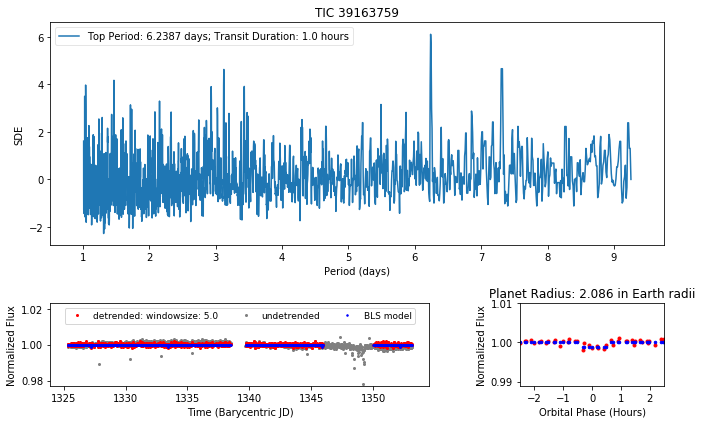


 
iteration 53
Applying Biweighted Midcorrelation Function...
 
iteration 54
Applying Biweighted Midcorrelation Function...
 
iteration 55
Applying Biweighted Midcorrelation Function...
 
iteration 56
Applying Biweighted Midcorrelation Function...
 
iteration 57
Applying Biweighted Midcorrelation Function...
 
iteration 58
Applying Biweighted Midcorrelation Function...
 
file:
TIC  50381137   3   3   Sector01
best period:  3.43294318904846
best T0:  1.5467866939611925


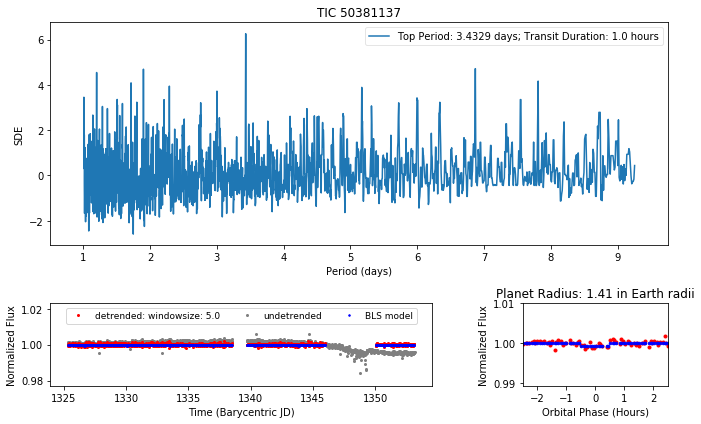


 
iteration 59
Applying Biweighted Midcorrelation Function...
 
iteration 60
Applying Biweighted Midcorrelation Function...
 
file:
TIC  52121469   1   3   Sector01
best period:  1.7129362770802756
best T0:  0.6177008732000138


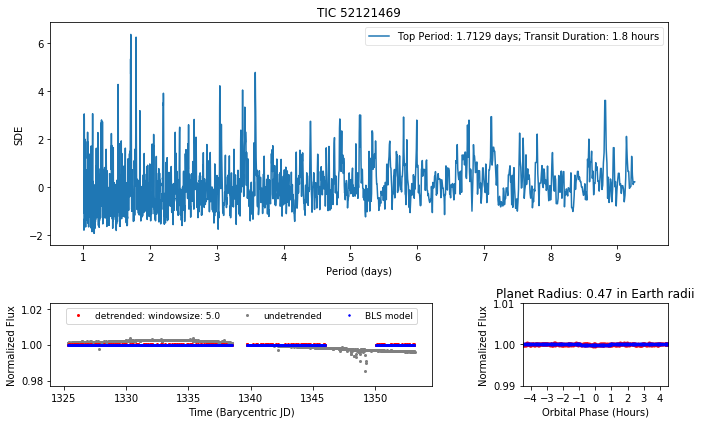


 
iteration 61
Applying Biweighted Midcorrelation Function...
 
iteration 62
Applying Biweighted Midcorrelation Function...
 
iteration 63
Applying Quasi Periodic GP...
Segment 1 of 3


/Users/felizd/anaconda/envs/py3.6/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([435337.67497253, -29364.08021545, 917408.73471355]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 4, 'warnflag': 2}
  ConvergenceWarning)


Segment 2 of 3
Segment 3 of 3


        Use astropy.stats.LombScargle instead. [__main__]


 
iteration 64
Applying Biweighted Midcorrelation Function...
 
iteration 65
Applying Biweighted Midcorrelation Function...
 
iteration 66
Applying Quasi Periodic GP...
Segment 1 of 3


/Users/felizd/anaconda/envs/py3.6/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 509672.11083317, -389703.37360859,  862534.84086514]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 88, 'nit': 4, 'warnflag': 2}
  ConvergenceWarning)


Segment 2 of 3


/Users/felizd/anaconda/envs/py3.6/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([135558.4609375 ,  17432.296875  , 516608.00909424]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 109, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)


Segment 3 of 3
 
file:
TIC  53781784   3   1   Sector01
best period:  5.446690474042513
best T0:  2.622655141002693


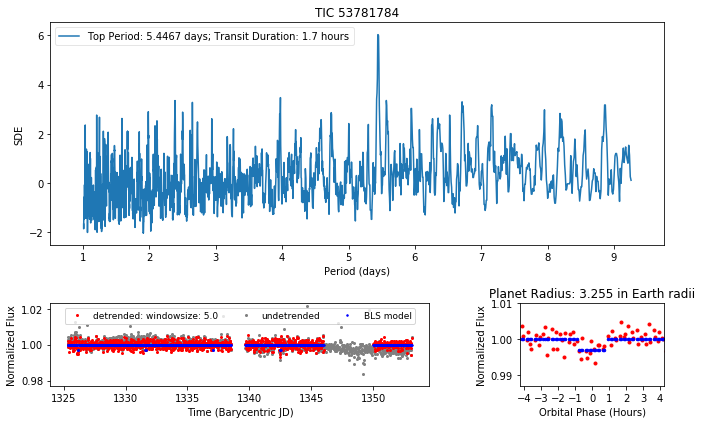


 
iteration 67
Applying Quasi Periodic GP...
Segment 1 of 3


        Use astropy.stats.LombScargle instead. [__main__]
/Users/felizd/anaconda/envs/py3.6/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 36101.5980835 , 637266.5803175 , 224562.11927032]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 102, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)


Segment 2 of 3


/Users/felizd/anaconda/envs/py3.6/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([243340.37566185, -10770.44874382,  55825.94961214]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 3, 'warnflag': 2}
  ConvergenceWarning)


Segment 3 of 3


        Use astropy.stats.LombScargle instead. [__main__]


 
iteration 68
Applying Biweighted Midcorrelation Function...
 
iteration 69
Applying Quasi Periodic GP...
Segment 1 of 3
Segment 2 of 3
Segment 3 of 3


        Use astropy.stats.LombScargle instead. [__main__]


 
iteration 70
Applying Biweighted Midcorrelation Function...
 
iteration 71
Applying Biweighted Midcorrelation Function...
 
iteration 72
Applying Biweighted Midcorrelation Function...
 
iteration 73
Applying Biweighted Midcorrelation Function...
 
iteration 74
Applying Biweighted Midcorrelation Function...
 
iteration 75
Applying Biweighted Midcorrelation Function...
 
iteration 76
Applying Quasi Periodic GP...
Segment 1 of 3
Segment 2 of 3


/Users/felizd/anaconda/envs/py3.6/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 20752.578125  ,  28794.48632812, 244628.94425964]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 82, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)


Segment 3 of 3


        Use astropy.stats.LombScargle instead. [__main__]


 
iteration 77
Applying Biweighted Midcorrelation Function...
 
file:
TIC  55557707   1   4   Sector01
best period:  7.48626654432359
best T0:  0.5256706547245864


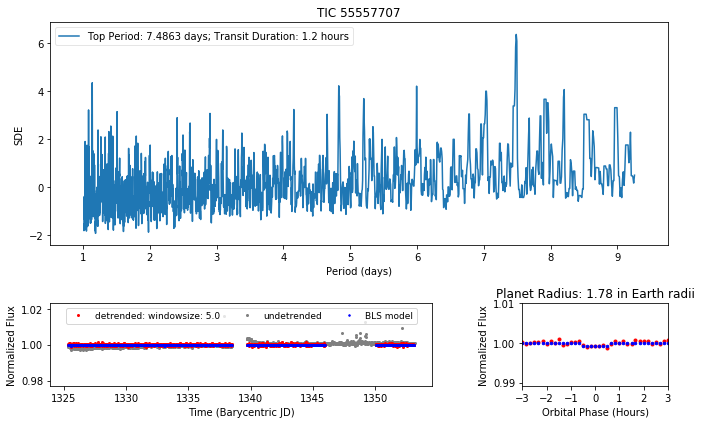


 
iteration 78
Applying Biweighted Midcorrelation Function...
 
iteration 79
Applying Biweighted Midcorrelation Function...
 
iteration 80
Applying Biweighted Midcorrelation Function...
 
iteration 81
Applying Quasi Periodic GP...
Segment 1 of 3


/Users/felizd/anaconda/envs/py3.6/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 21977.76625463, -56964.99656367,  32280.4268741 ]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 2, 'warnflag': 2}
  ConvergenceWarning)


Segment 2 of 3
Segment 3 of 3


        Use astropy.stats.LombScargle instead. [__main__]


 
iteration 82
Applying Biweighted Midcorrelation Function...
 
file:
TIC  61179982   2   1   Sector01
best period:  5.382597223171521
best T0:  2.0596147664725457


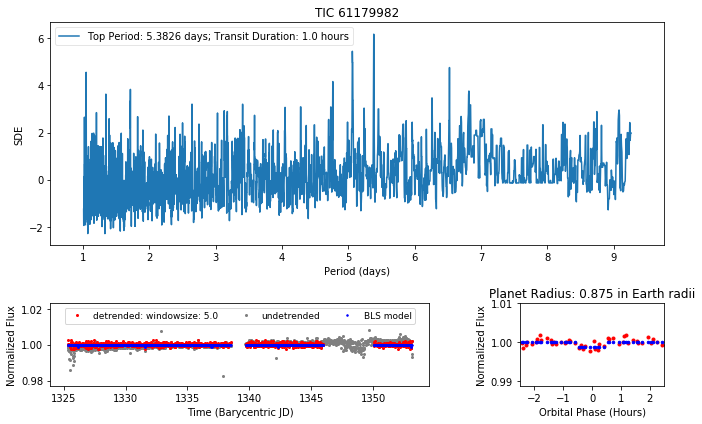


 
iteration 83
Applying Biweighted Midcorrelation Function...
 
iteration 84
Applying Biweighted Midcorrelation Function...
 
iteration 85
Applying Biweighted Midcorrelation Function...
 
iteration 86
Applying Biweighted Midcorrelation Function...
 
iteration 87
Applying Biweighted Midcorrelation Function...
 
iteration 88
Applying Biweighted Midcorrelation Function...
 
iteration 89
Applying Biweighted Midcorrelation Function...
 
file:
TIC  62220450   2   1   Sector01
best period:  9.099689678383957
best T0:  6.22769496765957


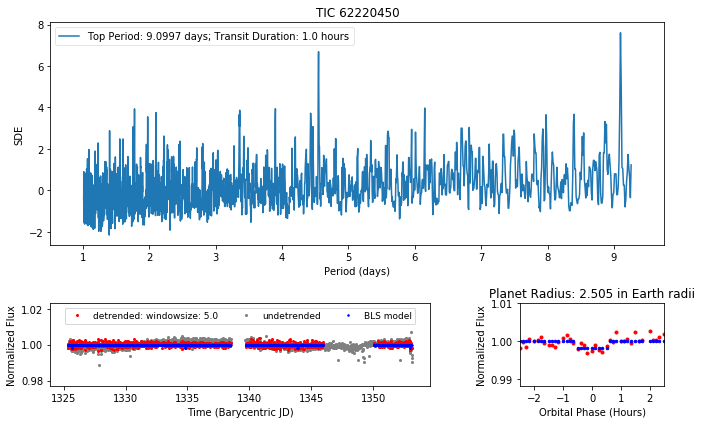


 
iteration 90
Applying Biweighted Midcorrelation Function...
 
file:
TIC  62762071   2   1   Sector01
best period:  6.926677472352749
best T0:  2.27937364160573


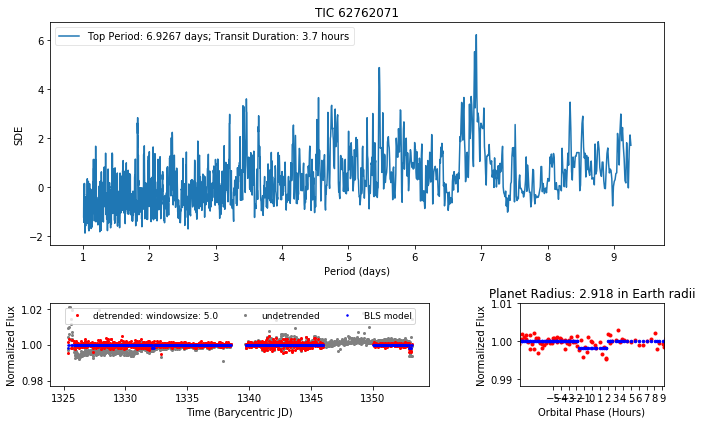


 
iteration 91
Applying Biweighted Midcorrelation Function...
 
iteration 92
Applying Biweighted Midcorrelation Function...
 
iteration 93
Applying Biweighted Midcorrelation Function...
 
iteration 94
Applying Biweighted Midcorrelation Function...
 
iteration 95
Applying Biweighted Midcorrelation Function...
 
iteration 96
Applying Biweighted Midcorrelation Function...
 
iteration 97
Applying Biweighted Midcorrelation Function...
 
file:
TIC  71274771   2   1   Sector01
best period:  6.8601418969241585
best T0:  1.6753122269706928


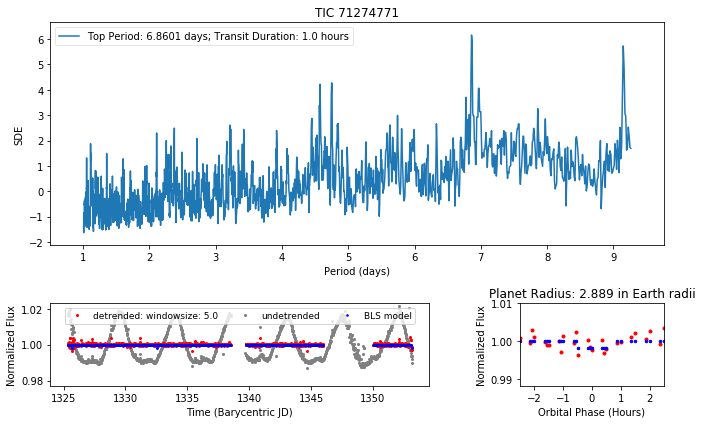


 
iteration 98
Applying Biweighted Midcorrelation Function...
 
iteration 99
Applying Biweighted Midcorrelation Function...
 
file:
TIC  71335815   4   2   Sector01
best period:  2.491822222948813
best T0:  2.187198391231316


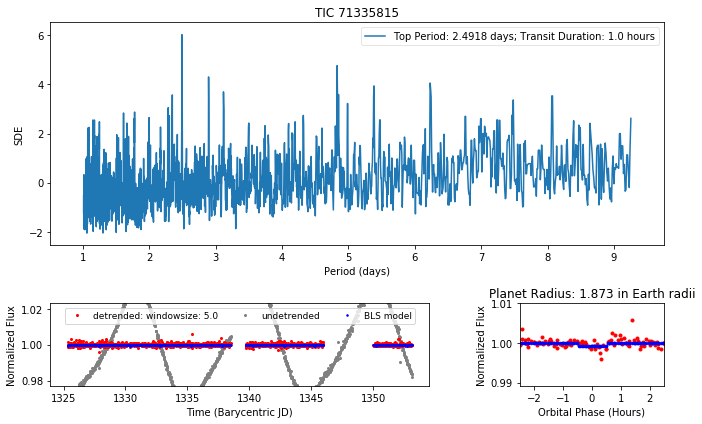


 
iteration 100
Applying Biweighted Midcorrelation Function...


/Users/felizd/anaconda/envs/py3.6/lib/python3.6/socket.py:657: ResourceWarning: unclosed <socket.socket fd=66, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('10.0.0.86', 65158), raddr=('130.167.165.61', 443)>
  self._sock = None


In [26]:
spacing = 0.02
SDE_threshold=6
fs = 9
#for reporting BLS model's planet radius
R_earth = 6.378*10.0**8.0 #cm
R_sun = 6.955*10.0**10.0 #cm

# for ii in range(len(data)): #creating a for loop to show light curve figures for all files
for ii in range(100): #creating a for loop to show light curve figures for all files    
    
    time     = np.transpose(np.loadtxt(data[ii]))[0] #first  (zero indexing in python) column 
    mag      = np.transpose(np.loadtxt(data[ii]))[1] #second (zero indexing in python) column 
    magerror = np.transpose(np.loadtxt(data[ii]))[2] #third (zero indexing in python) column 
    
    mask = np.where(np.isnan(mag)==False)[0] #creating array of only real numbers by setting np.isnan(mag)==False. 
    time = time[mask]                        #Sometimes there are holes in data filled with NaNs
    mag = mag[mask]
    magerror = magerror[mask]
    
    flux = 10.0**(mag/-2.5)/np.mean(10.0**(mag/-2.5))
    fluxerror = flux*(10.0**(magerror/2.5)-1.0)
    
    #known bad data points with high telescope jitter:
    if SectorNum==1:
        jittermask = (time < 1346) | (time > 1350)
    
    #removing outliers with Chauvenet's criterion
    t2,f2,fe2 = ChauventsCriteron(time[jittermask],flux[jittermask],fluxerror[jittermask])
    
    lc = lk.LightCurve(t2,f2,fe2) #outlier removed only
    
    #check for rapid rotators with Lomb-Scargle (P_rot < 2 days)
    period = 10 ** np.linspace(np.log10(0.1), np.log10(3), 1000)
    freq = 2.0 * np.pi / period
    PS = lomb_scargle(t2,f2,fe2,omega=freq, generalized=True)
    Standpower = (PS-np.mean(PS))/np.std(PS)
    print(" ")    
    print("iteration",ii+1)
    
    if period[np.argmax(Standpower)] < 2:

        print("Applying Quasi Periodic GP...")
        length_scale=2 # 1 to 2 is generally pretty good from my tests
        gpflatten_lc, gptrend_lc = flatten(t2,f2,method='gp', \
                                             kernel='periodic_auto',kernel_size=length_scale,return_trend=True,robust=True)
        
        T=t2
        F= gpflatten_lc
        FE = fe2
    else:

        print("Applying Biweighted Midcorrelation Function...")
        window_size_wotan = 5.0/24.0 # The length of the filter window in units of time (days)
        flatten_lc, trend_lc = flatten(t2, f2, window_length=window_size_wotan, return_trend=True, method='biweight',robust=True)
        T=t2
        F=flatten_lc
        FE=fe2

    #checking for NaNs
    nanmask = np.where(np.isnan(F)==False)[0]
    T = T[nanmask]
    F = F[nanmask]
    FE =FE[nanmask]


#     Try another iteration of outlier removal
    T,F,FE = ChauventsCriteron(T,F,FE)
    
    ID = (os.path.basename(data[ii]).split)('_')[0]


    Sector = "S"+(os.path.basename(data[ii]).split)('_')[1][1:] #by default, this has lower case "s"
    #^^^ so I added a capital "S" and remove the first element ("s") of this string
    # with this index slice [1:]. This isn't really imporant, just being tidy.

    Camera = (os.path.basename(data[ii]).split)('_')[2] 
    CCD = (os.path.basename(data[ii]).split)('_')[3][-4]
    
    
    #doing BLS search:
    
    qld, R_star, R_star_min, R_star_max, M_star, M_star_min, M_star_max = catalog_info(TIC_ID=int(ID))   
    #^^^ grabbing stellar information from MAST catalogs
    
    if np.isfinite(R_star)==True and np.isfinite(M_star)==True: #checks to see if stellar information is unknown in MAST catalogs
        minP=1.01
        maxP= (max(t2_wotan)-min(t2_wotan)) #length of our light curve
        minDur = 1.0/24.0
        maxDur = 5.0/24.0
        
        #creating list of orbital periods to model with
        periods = period_grid(R_star=R_star, M_star=M_star, time_span=maxP, period_min=minP, period_max=maxP/3.0)#,oversampling_factor=10)

        durations = np.linspace(minDur,maxDur,25)
    
        bls = BoxLeastSquares(T,F,FE)
        bls_power = bls.power(periods, durations)
        bls_SDE = (bls_power.power - np.mean(bls_power.power))/np.std(bls_power.power)
        
        #phase folding with best BLS model
        index = np.argmax(bls_power.power); 
        best_period = bls_power.period[index]; 
        best_duration = bls_power.duration[index]
        best_t0 = bls_power.transit_time[index];
        BLS_depths=bls_power.depth[index]
        dur = minDur #0.5

        #creating the best fit box model to our data
        bls_model=bls.model(T,bls_power.period[index], bls_power.duration[index], bls_power.transit_time[index])
        
        #calculating planet radius fit by BLS
        R_p = np.sqrt(BLS_depths)*R_star*R_sun/R_earth
        
        
        p = best_period
        x_fold = (T - best_t0 + 0.5*p) % p - 0.5*p
        x_fold_raw = (time - best_t0 + 0.5*p) % p - 0.5*p
        
        detrendedphasefoldedlc = [x_fold, F, FE]
        phasefoldedlc = [x_fold_raw,flux,fluxerror]


        if len(np.where(bls_SDE>SDE_threshold)[0])>0:
            print(" ")
            print("file:")
            print("TIC ", ID, " ",CCD, " ",Camera, " ",Sector)
            print("best period: ", best_period)
            print("best T0: ",best_t0)

            gs1 = gridspec.GridSpec(3, 3)
            gs1.update(left=0.65, right=1.25, wspace=0.25,hspace=0.5)


            f = plt.figure(figsize=(10,6))
            ax1 = f.add_subplot(gs1[:-1, :])
            ax2 = f.add_subplot(gs1[-1, :-1])
            ax3 = f.add_subplot(gs1[-1, -1])

            ax1.plot(bls_power.period, bls_SDE, rasterized=True, label='Top Period: '+str( np.round(best_period,4) )+" days; Transit Duration: "+str(np.round(24*best_duration,4))+" hours") #rounding period to 4 decimal places 
            ax1.set_xticks(np.arange(0.0, 10.0, 1.0))
            ax1.set_title("TIC "+ ID)
            ax1.set_xlabel("Period (days)")
            ax1.set_xlim(np.min(bls_power.period)-0.5, np.max(bls_power.period)+0.5)
            ax1.set_ylabel("SDE")
            ax1.set_ylim(np.min(bls_SDE)-0.5, np.max(bls_SDE)+0.5)
            ax1.legend(loc='best',fancybox=True,framealpha=0.5)

            ax2.plot(T, F ,c='red',markersize=4,marker='.',linestyle='none',zorder=1,label='detrended: windowsize: '+str(window_size_wotan*24))#+", binsize: "+str(bin_size)) 
            ax2.plot(time,flux,c='grey',marker='.',markersize=4,linestyle='none',zorder=0,label='undetrended')
            ax2.plot(T,bls_model,'b.',markersize=3,label='BLS model')
            ax2.legend(loc='upper center',ncol=3,fontsize=fs)
            ax2.set_ylim(np.min(f2_wotan)-spacing, np.max(f2_wotan)+spacing)
            ax2.set_xlabel("Time (Barycentric JD)")
            ax2.set_ylabel("Normalized Flux") 

            ax3.plot(24*x_fold,detrendedphasefoldedlc[1],c='red',markersize=6,marker='.',linestyle='none',zorder=1,label='detrended: windowsize: '+str(window_size_wotan*24))#+", binsize: "+str(bin_size))
#             ax3.plot(24*x_fold_raw,phasefoldedlc[1],c='grey',marker='.',markersize=6,linestyle='none',zorder=0,label='undetrended')
            ax3.plot(24*x_fold,bls_model,'b.',markersize=5,label='BLS model')
            ax3.set_title("Planet Radius: "+str(np.round(R_p,3))+" in Earth radii")
            ax3.set_xlabel("Orbital Phase (Hours)")
            ax3.set_ylabel("Normalized Flux") 
            ax3.set_ylim(np.min(bls_model)-spacing+0.01, np.max(bls_model)+spacing-0.01)
            ax3.set_xticks(np.arange(-5,10,1)) #hours
            ax3.set_xlim(-2.5*best_duration*24,2.5*best_duration*24)
            gs1.tight_layout(f)

            plt.savefig(figpath+"TIC_"+ID+"_"+Sector+"_Camera_"+Camera+"_CCD_"+CCD+"_BLS.png")
            plt.show()    
            print( "") #adds space between figures
    else:
        continue
        print(" ") #adds space between figures
            
        
        
    
    